# **Time series analysis of flight delays**

# Introduction

This project aims at performing a time series analysis to forecast the departure delays in the US from 2019 to 2023 and presents with an opportunity to analyse the challenges and enhance the operational efficiency and passenger satisfaction in the aviation industry. The project begins with a comprehensive examination of historical flight data, focusing on the `DEP_DELAY` variable that represents the length of delay at the time of departure. The data is preprocessed to handle irregularities, such as missing values and outliers, which are common in real-world datasets. And thereater a extensive EDA is performed to explore the data for underlying patterns and trends using visual and statistical methods. 

The ultimate goal is to deliver a robust predictive model that can be used by stakeholders to anticipate and manage departure delays, thereby minimizing their impact on flight schedules and passenger plans.

In [1]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [2]:
# Preparing the dataset for EDA
df_full = pd.read_csv('/kaggle/input/flights-sample-3m/flights_sample_3m.csv', usecols=['FL_DATE', 'DEP_DELAY', 'ARR_DELAY'])

# Converting FL_DATE to datetime and setting it as the index
df_full['FL_DATE'] = pd.to_datetime(df_full['FL_DATE'])
df_full.set_index('FL_DATE', inplace=True)

# Aggregating data to daily average delays
daily_avg_delays = df_full.resample('D').mean()

# Displaying the first few rows to verify the transformation
daily_avg_delays.head()

,DEP_DELAY,ARR_DELAY
FL_DATE,,
2019-01-01,10.530790,4.532751
2019-01-02,12.479763,7.840909
2019-01-03,10.310448,3.159521
2019-01-04,5.157555,-2.774515
2019-01-05,7.342874,0.227885


# EDA - Seaonal Decomposition 

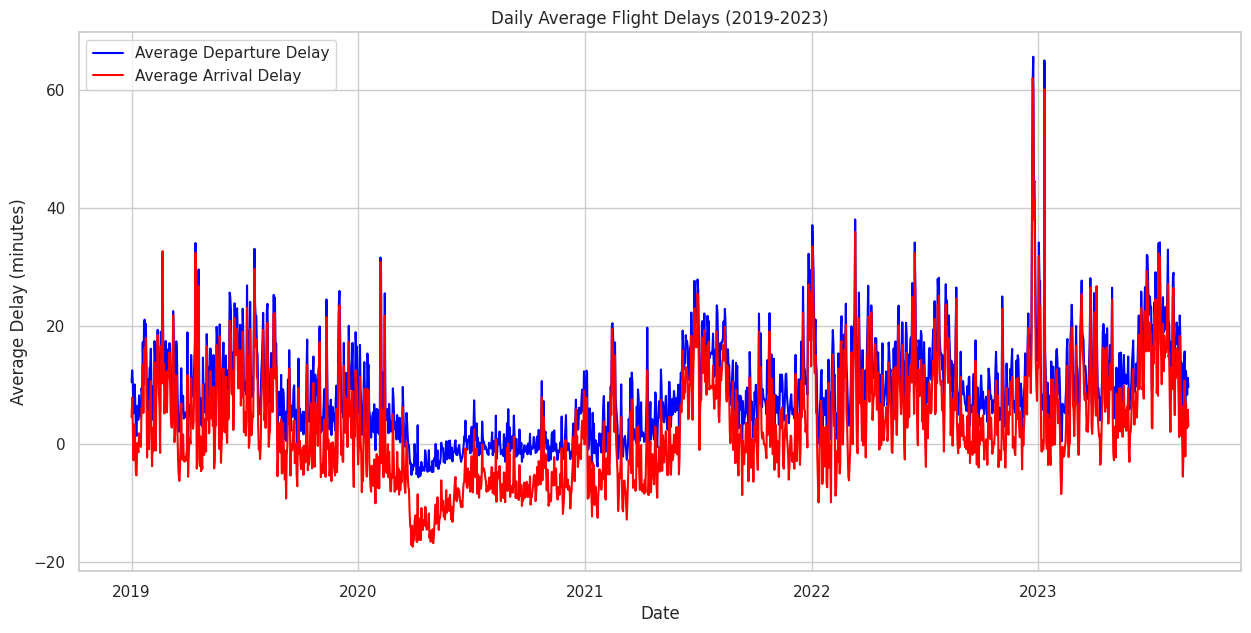

In [3]:
# Setting the visual style
sns.set(style="whitegrid")

# Plotting the daily average departure and arrival delays
plt.figure(figsize=(15, 7))
plt.plot(daily_avg_delays.index, daily_avg_delays['DEP_DELAY'], label='Average Departure Delay', color='blue')
plt.plot(daily_avg_delays.index, daily_avg_delays['ARR_DELAY'], label='Average Arrival Delay', color='red')
plt.title('Daily Average Flight Delays (2019-2023)')
plt.xlabel('Date')
plt.ylabel('Average Delay (minutes)')
plt.legend()
plt.show()

Resampling the time series data to a daily frequency ('D'), grouping the data by each day and then calculating the mean of each group. 'daily_avg_delays': daily average values of flight delays

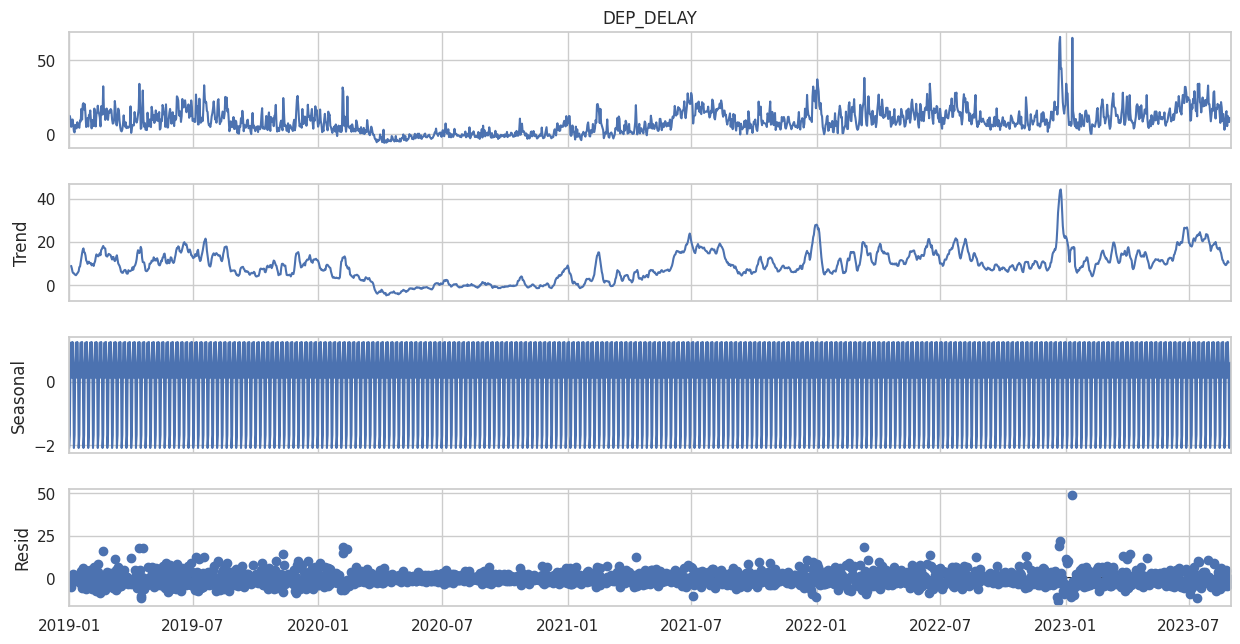

In [4]:
# Decomposing the daily average departure delays
decomposition = seasonal_decompose(daily_avg_delays['DEP_DELAY'], model='additive')

# Plotting the decomposed time series components
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

X-axis: data in range 2019 to sometime in 2023. 
Y-axis: the magnitude of the departure delays, trend, seasonal effect, and residuals.
First graph shows the orignial time series data with the daily average departure delays, next one shows the trend of long term progression of the original time series. Third graph shows the seasonality component which in this case is on daily basis and shows a consyant pattern indicadting that as it is plotted against several years of data, daily fluctuations can blend together and look like a solid, unchanging band.The last graph is the spread of the residuals and it seems to be consistent over time, suggesting homoscedasticity, which means the variance of the residuals is fairly uniform. There are a few points that stand out from the zero line, which could be considered as outliers.

In [5]:

flights_data = pd.read_csv('/kaggle/input/flights-sample-3m/flights_sample_3m.csv', parse_dates=['FL_DATE'])

# Set date as index 
flights_data.set_index('FL_DATE', inplace=True)

# Creating new features
# Time of Day
flights_data['hour_of_day'] = flights_data['CRS_DEP_TIME'].apply(lambda x: int(str(x).zfill(4)[:2]))

# Day of the Week
flights_data['day_of_week'] = flights_data.index.dayofweek

# Month and Season
flights_data['month'] = flights_data.index.month
flights_data['season'] = flights_data['month'] % 12 // 3 + 1

# Weekend Indicator
flights_data['is_weekend'] = flights_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Create categories for distance
flights_data['distance_category'] = pd.cut(flights_data['DISTANCE'], bins=[0, 500, 1000, 1500, 2000, float('inf')], 
                                           labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])

print(flights_data.head())

                          AIRLINE                AIRLINE_DOT AIRLINE_CODE  \
FL_DATE                                                                     
2019-01-09  United Air Lines Inc.  United Air Lines Inc.: UA           UA   
2022-11-19   Delta Air Lines Inc.   Delta Air Lines Inc.: DL           DL   
2022-07-22  United Air Lines Inc.  United Air Lines Inc.: UA           UA   
2023-03-06   Delta Air Lines Inc.   Delta Air Lines Inc.: DL           DL   
2020-02-23       Spirit Air Lines       Spirit Air Lines: NK           NK   

            DOT_CODE  FL_NUMBER ORIGIN          ORIGIN_CITY DEST  \
FL_DATE                                                            
2019-01-09     19977       1562    FLL  Fort Lauderdale, FL  EWR   
2022-11-19     19790       1149    MSP      Minneapolis, MN  SEA   
2022-07-22     19977        459    DEN           Denver, CO  MSP   
2023-03-06     19790       2295    MSP      Minneapolis, MN  SFO   
2020-02-23     20416        407    MCO          Orla

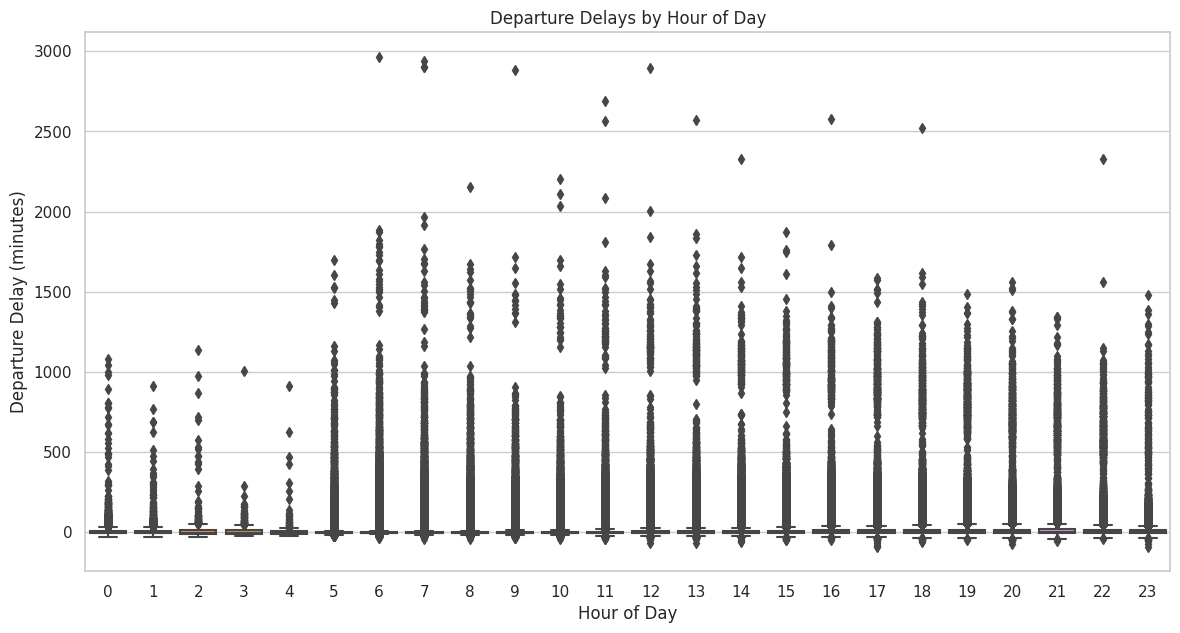

In [6]:
# Set the visualisation style
sns.set(style="whitegrid")
 
# EDA: Departure Delays by Hour of Day
plt.figure(figsize=(14, 7))
sns.boxplot(x='hour_of_day', y='DEP_DELAY', data=flights_data)
plt.title('Departure Delays by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Departure Delay (minutes)')
plt.show()



The median delay across most hours seems to be quite low and there is a significant variation in delays, as shown by the range of the boxes and the whiskers for each hour. There are many outliers, especially in the daytime and evening hours, indicating that while most delays are moderate, there are quite a few instances of extreme delays. Certain hours in the evening show a higher median delay, indicating that more than half of the delays recorded during these times are on the higher side compared to other hours.

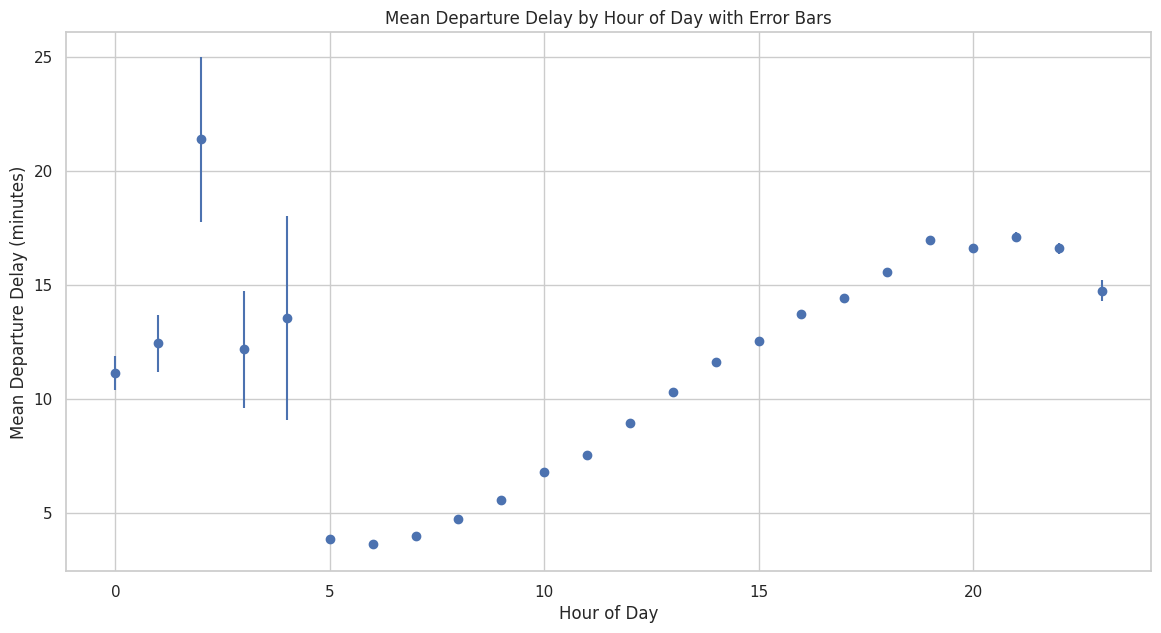

In [7]:
# Function to calculate mean and standard error for plotting with error bars
def mean_sem(group):
    return {'mean': group.mean(), 'sem': group.sem()}

# Mean and standard error of departure delays by hour of day
hourly_delay = flights_data.groupby('hour_of_day')['DEP_DELAY'].apply(mean_sem).unstack()

# Plotting mean departure delay by hour of day with error bars
plt.figure(figsize=(14, 7))
plt.errorbar(x=hourly_delay.index, y=hourly_delay['mean'], yerr=hourly_delay['sem'], fmt='o')
plt.title('Mean Departure Delay by Hour of Day with Error Bars')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Departure Delay (minutes)')
plt.grid(True)
plt.show()

The points indicate the average departure delay for flights at different hours of the day. The error bars show the variability around the mean, which can be interpreted as the range within which we expect the true mean delay to fall. They appear to represent one standard error above and below the mean. There's a clear pattern where the mean delay increases during certain hours of the day, peaking in the late afternoon and evening. This suggests that flights are more likely to be delayed during these hours. The variability also seems to increase during the day, with wider error bars observed in the afternoon and evening, indicating less consistency in flight delays during these times.

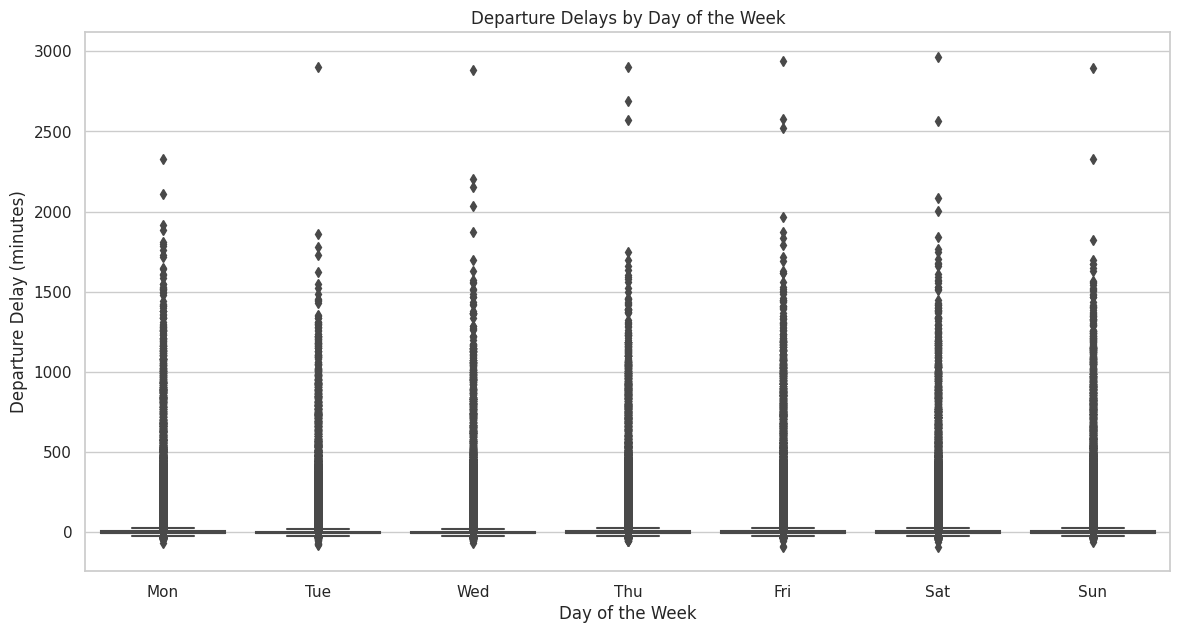

In [8]:
# EDA: Departure Delays by Day of Week
plt.figure(figsize=(14, 7))
sns.boxplot(x='day_of_week', y='DEP_DELAY', data=flights_data)
plt.title('Departure Delays by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Departure Delay (minutes)')
# Setting the x-axis labels to be more descriptive
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


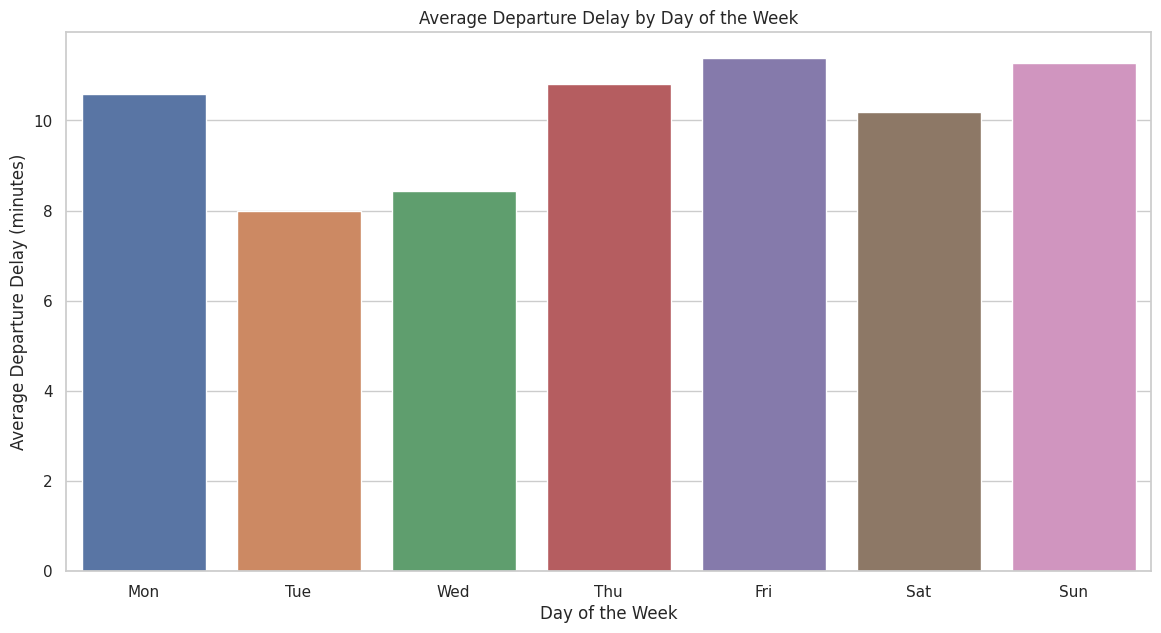

In [9]:
# Bar plot for mean departure delay by day of the week
plt.figure(figsize=(14, 7))
weekday_mean_delays = flights_data.groupby('day_of_week')['DEP_DELAY'].mean()
sns.barplot(x=weekday_mean_delays.index, y=weekday_mean_delays.values)
plt.title('Average Departure Delay by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

There is a consistent pattern of delays throughout the week and no single day stands out as having markedly longer delays.
The mean departure is slightly lower of tuesdays and Wednesdays. 

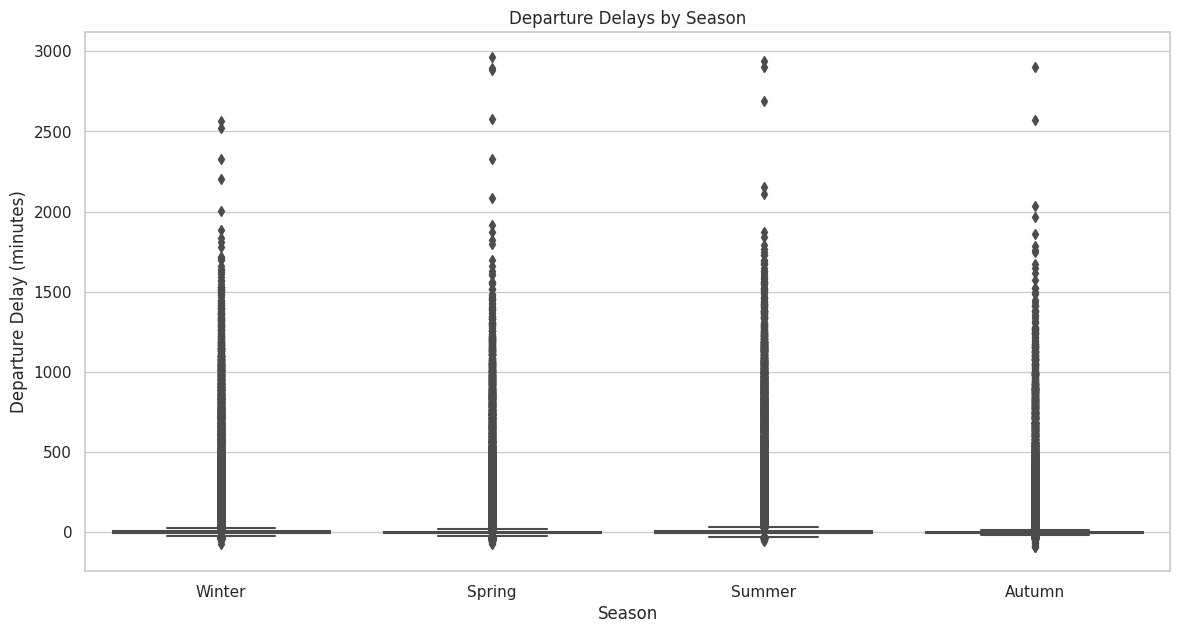

In [10]:
# EDA: Departure Delays by Season
plt.figure(figsize=(14, 7))
sns.boxplot(x='season', y='DEP_DELAY', data=flights_data)
plt.title('Departure Delays by Season')
plt.xlabel('Season')
plt.ylabel('Departure Delay (minutes)')
# Setting the x-axis labels to be more descriptive
plt.xticks(ticks=[0, 1, 2, 3], labels=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.show()

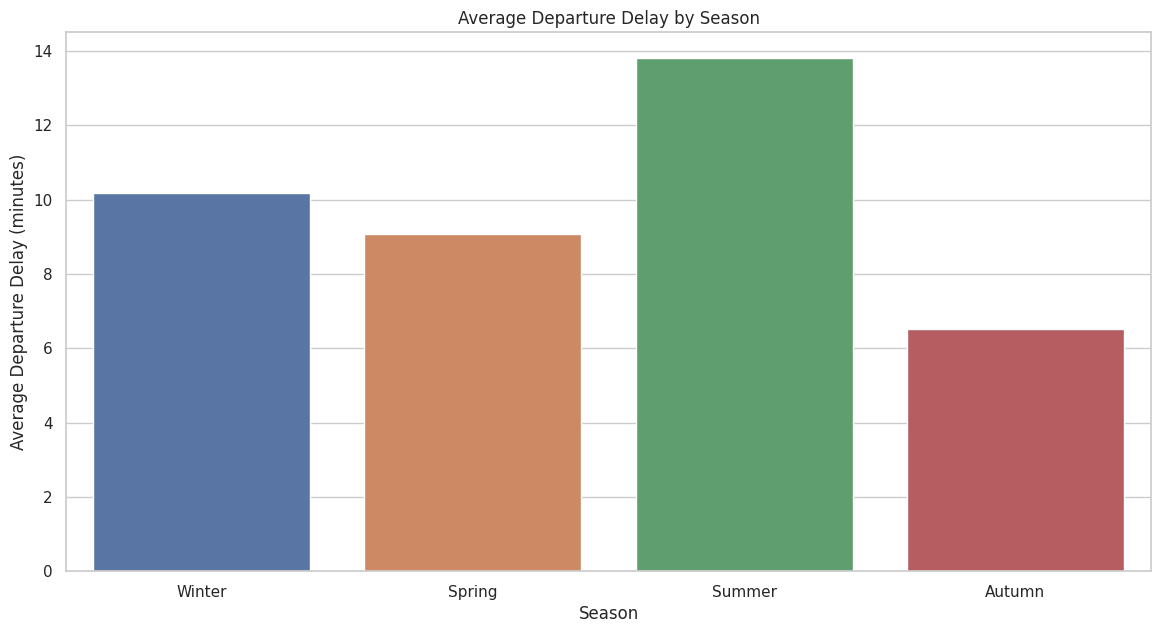

In [11]:
# Bar plot for mean departure delay by season
plt.figure(figsize=(14, 7))
season_mean_delays = flights_data.groupby('season')['DEP_DELAY'].mean()
sns.barplot(x=season_mean_delays.index, y=season_mean_delays.values)
plt.title('Average Departure Delay by Season')
plt.xlabel('Season')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.show()


Winter has the highest average delay, which could be attributed to winter weather conditions affecting flight operations. Summer also shows a high average delay, which might be due to increased travel activity. 
Spring and autumn show lower average delays, which might be due to more favorable weather conditions and possibly fewer flights compared to the high travel seasons.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


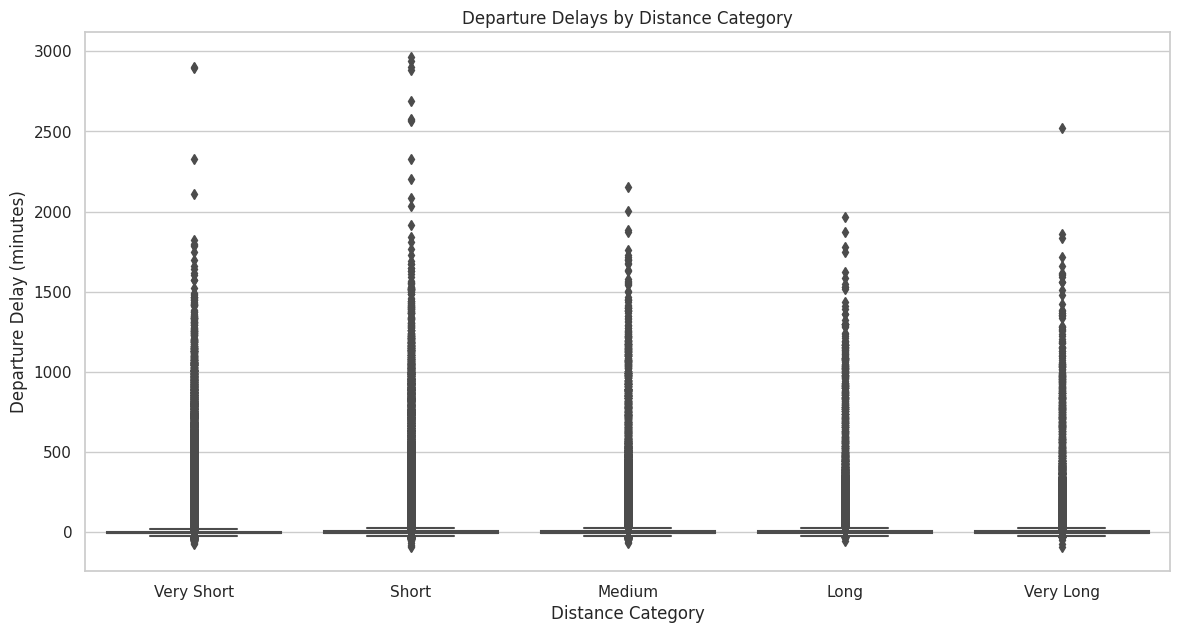

In [12]:
# EDA: Departure Delays by Distance Category
plt.figure(figsize=(14, 7))
sns.boxplot(x='distance_category', y='DEP_DELAY', data=flights_data)
plt.title('Departure Delays by Distance Category')
plt.xlabel('Distance Category')
plt.ylabel('Departure Delay (minutes)')
plt.show()


The ‘Very Short’ and ‘Very Long’ distance categories have a higher median delay as compared to the other three categories. Additionally, the very long flights also experiencing some of the most extreme delays. 

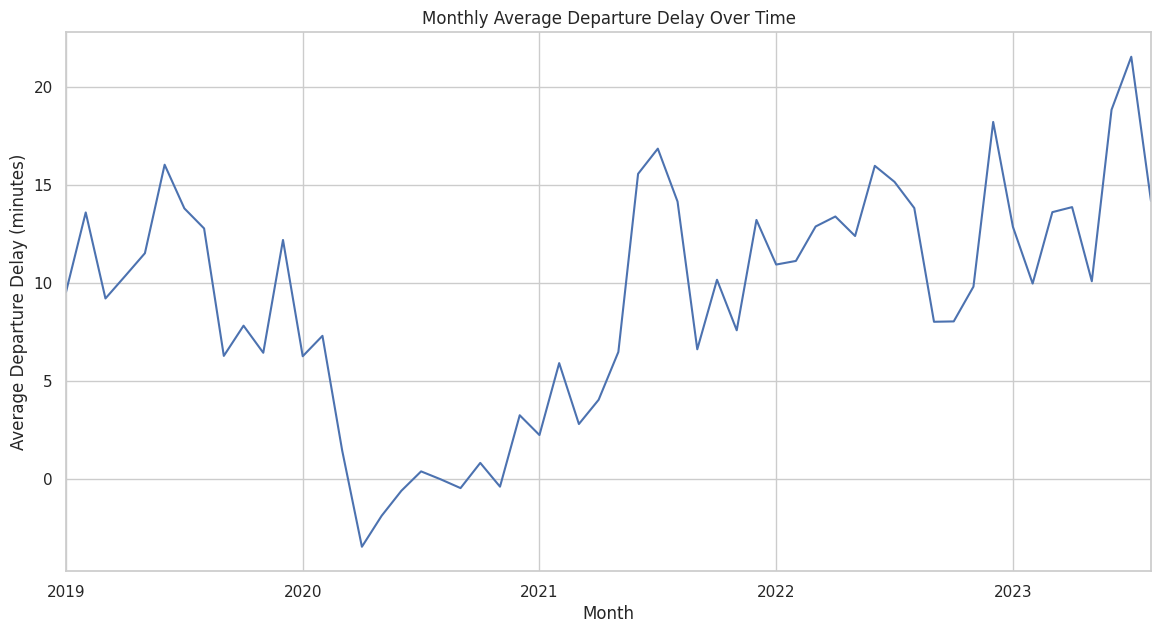

In [13]:
plt.figure(figsize=(14, 7))
flights_data['DEP_DELAY'].resample('MS').mean().plot()
plt.title('Monthly Average Departure Delay Over Time')
plt.xlabel('Month')
plt.ylabel('Average Departure Delay (minutes)')
plt.show()


There is some seasonality in the data, with peaks and troughs corresponding to specific times of the year. Starting from around the beginning of 2021, there's a noticeable upward trend in the average departure delay. This trend continues into 2022 and 2023, suggesting that, on average, delays have been getting longer over these years.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


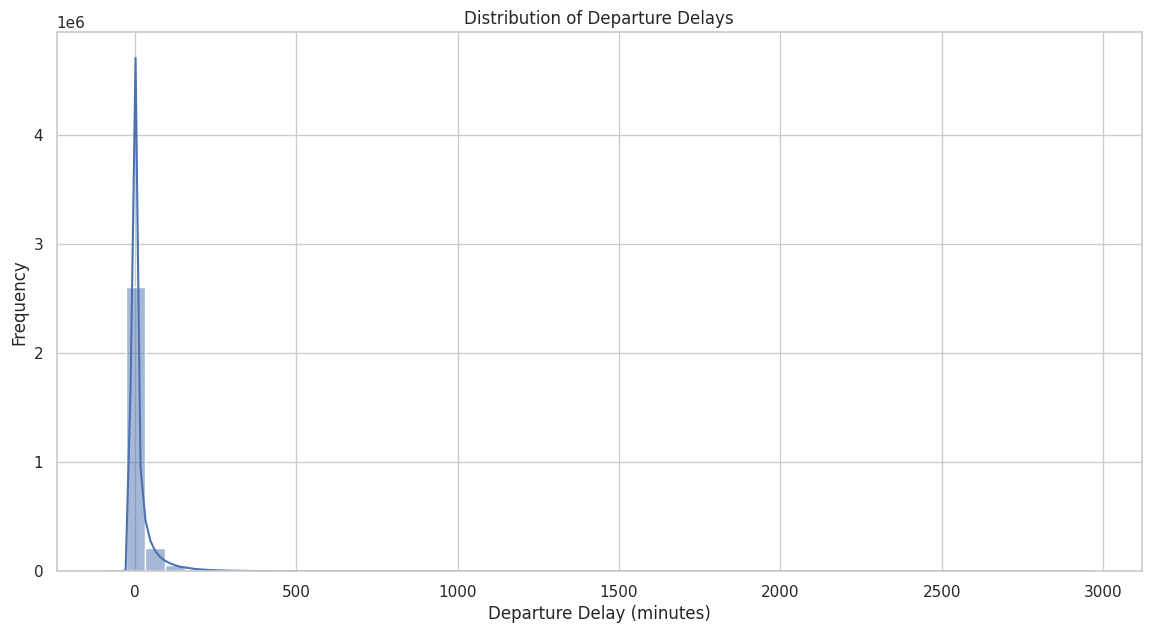

In [14]:
# KDE plot of departure delays
plt.figure(figsize=(14, 7))
sns.histplot(flights_data['DEP_DELAY'].dropna(), bins=50, kde=True)  # Drop NaN values for this plot
plt.title('Distribution of Departure Delays')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.show()

The distribution is right-skewed, indicating that there are more instances of shorter delays and much fewer instances of longer delays. The long tail extending to the right shows that there are relatively few flights with large delays.

/tmp/ipykernel_18/619099358.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='mean', y='AIRLINE', data=airline_delays, ci='sd')  # 'ci' for confidence interval, which here means standard deviation


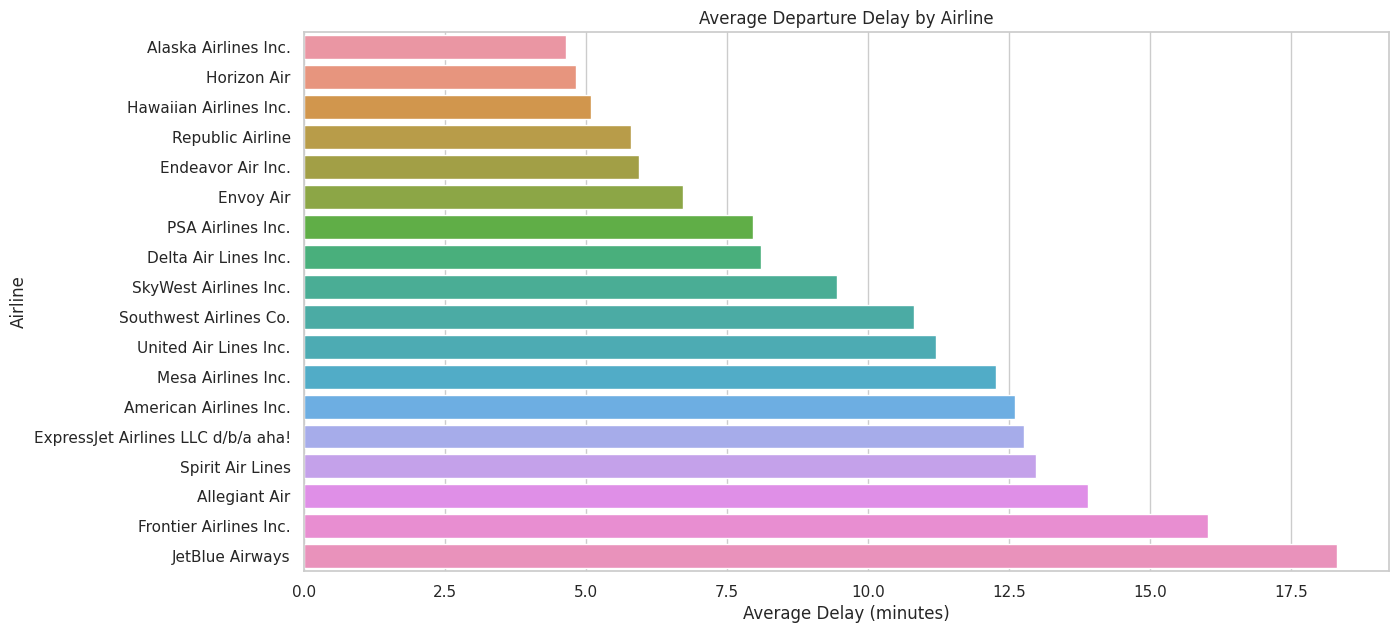

In [15]:
# Grouping the data by 'AIRLINE' and calculate mean and standard deviation of 'DEP_DELAY'
airline_delays = flights_data.groupby('AIRLINE')['DEP_DELAY'].agg(['mean', 'std']).reset_index()

# Sorting the results for better visualization
airline_delays = airline_delays.sort_values(by='mean')

# Bar plot of average delays by airline
plt.figure(figsize=(14, 7))
sns.barplot(x='mean', y='AIRLINE', data=airline_delays, ci='sd')  # 'ci' for confidence interval, which here means standard deviation
plt.xlabel('Average Delay (minutes)')
plt.ylabel('Airline')
plt.title('Average Departure Delay by Airline')
plt.show()



The specific positioning describes how long is the delay and how predictable are they. Airlines at the top of the chart such as Alaska and Horizon are generally more reliable in terms of having lower and more consistent departure delays, while those at the bottom like Frontier and JetBlue have longer and more unpredictable delay patterns.

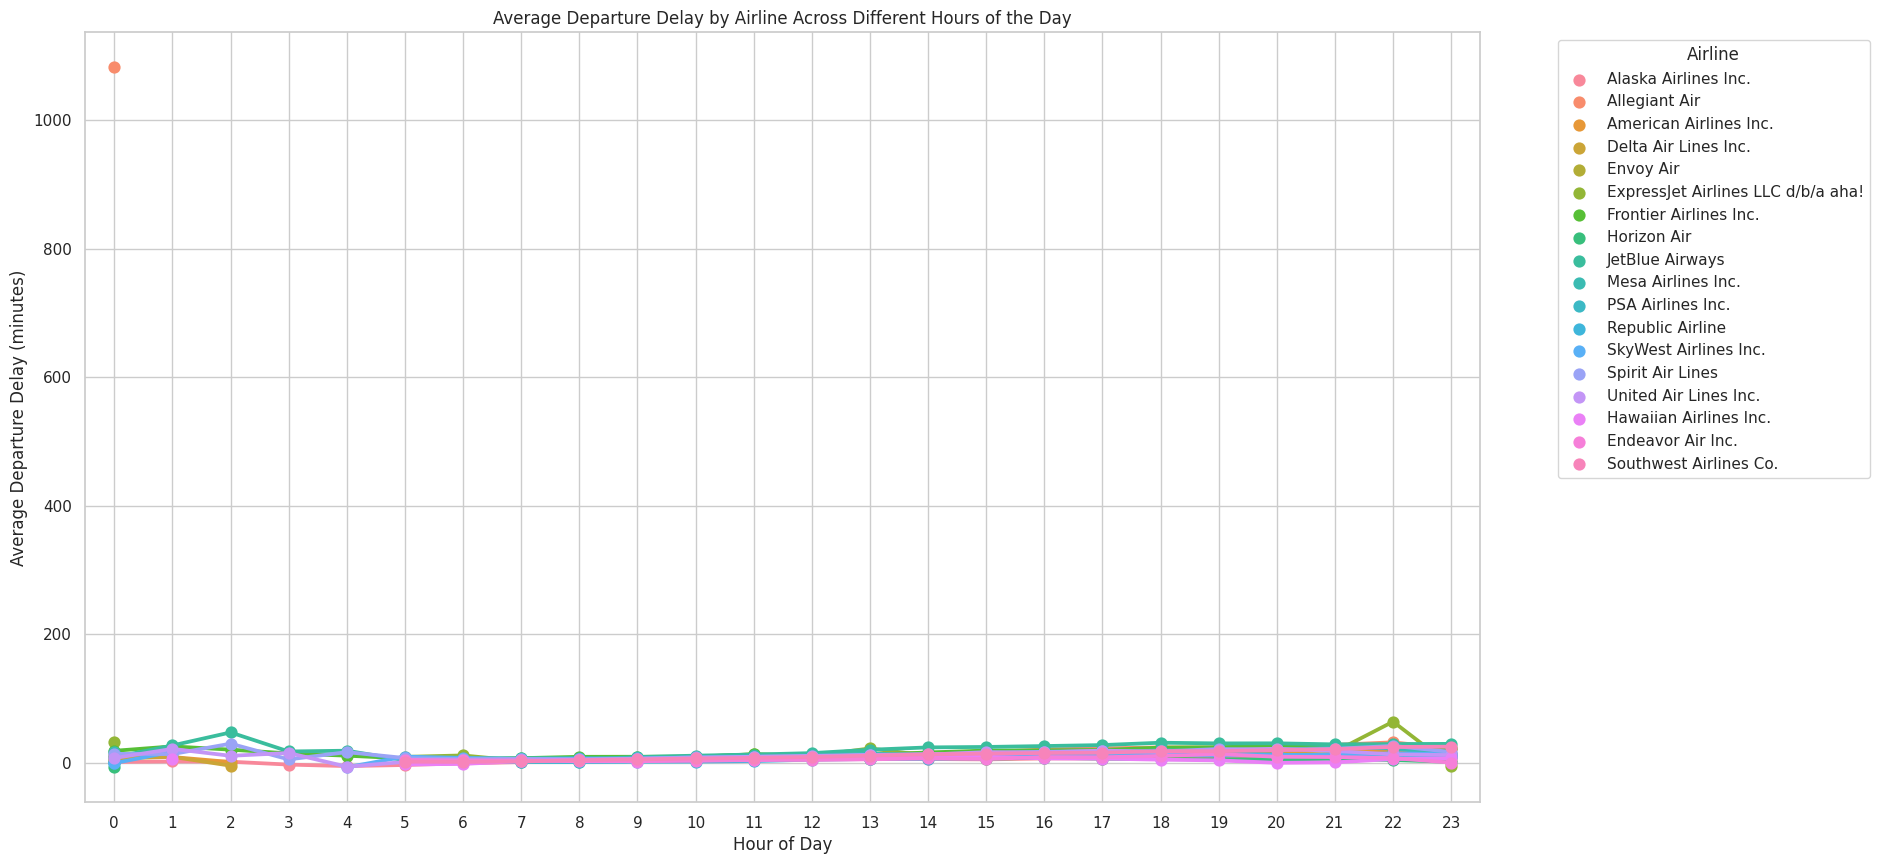

In [16]:
# Grouping the data by 'hour_of_day' and 'AIRLINE', then calculate the mean delay
hourly_airline_delay = flights_data.groupby(['hour_of_day', 'AIRLINE'])['DEP_DELAY'].mean().reset_index()

# Creating a point plot to show the interaction between airline and hour of day for delays
plt.figure(figsize=(18, 10))
sns.pointplot(x='hour_of_day', y='DEP_DELAY', hue='AIRLINE', data=hourly_airline_delay)
plt.title('Average Departure Delay by Airline Across Different Hours of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Departure Delay (minutes)')
plt.legend(title='Airline', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend out of the plot
plt.grid(True)
plt.show()


Most airlines seem to have a relatively low and consistent average departure delay across all the hours.

/tmp/ipykernel_18/420347871.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='hour_of_day', y='DEP_DELAY', hue='AIRLINE', data=top_hourly_delay,


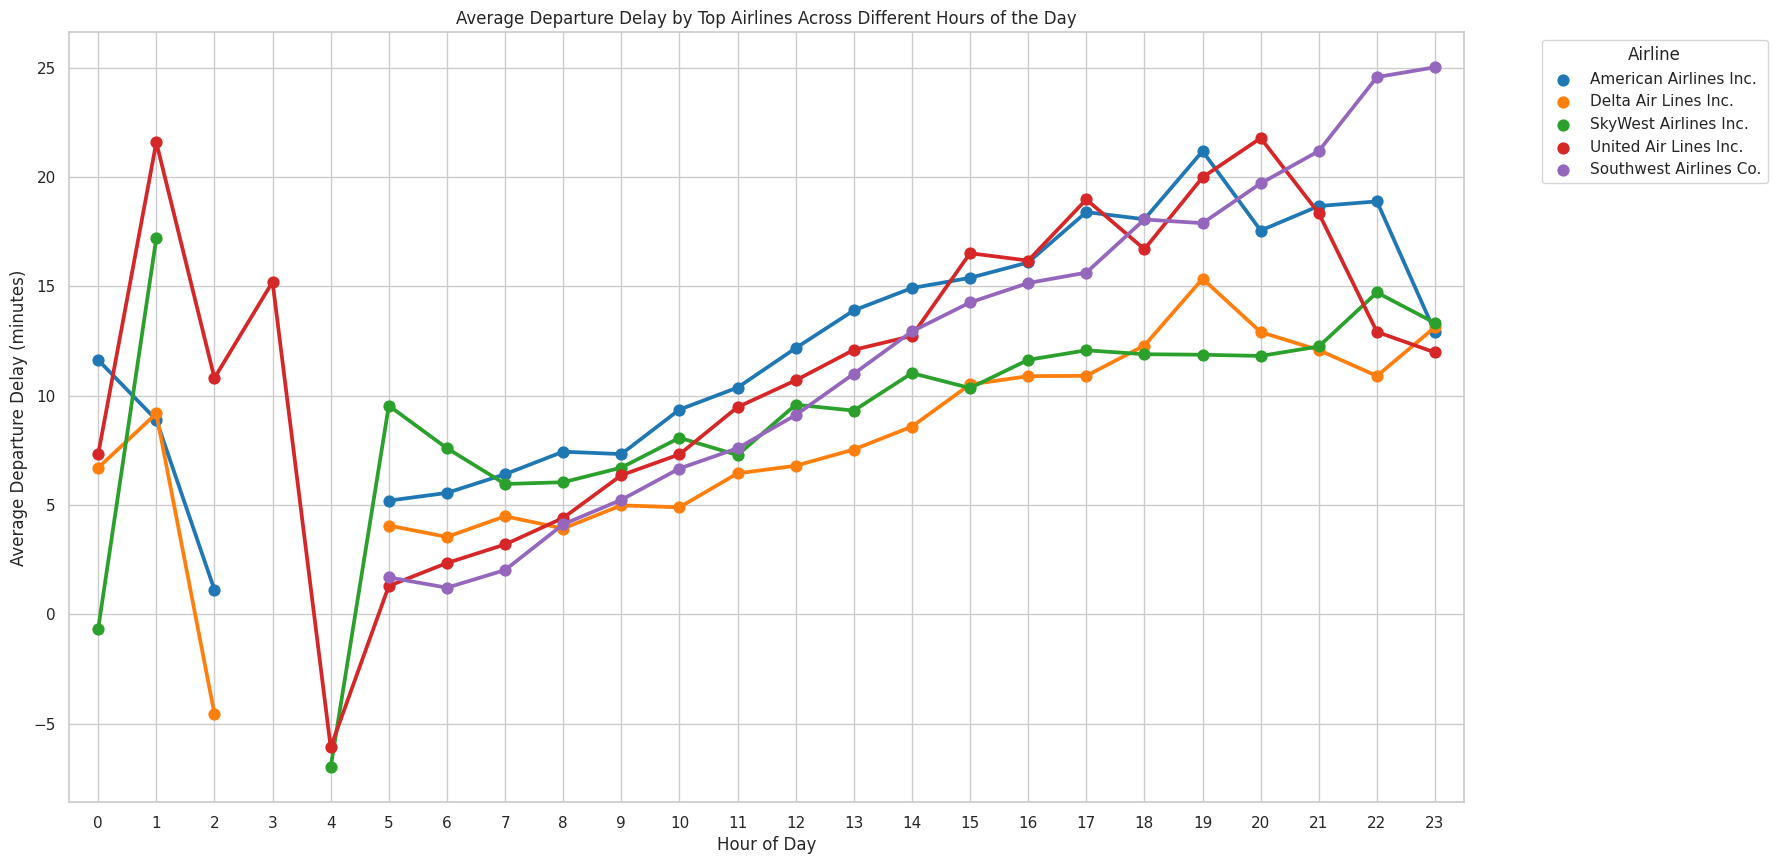

In [17]:
 # Step 1: Identifying the airlines with the most flights
top_airlines = flights_data['AIRLINE'].value_counts().nlargest(5).index

# Step 2: Filtering the dataset to include only the top airlines
top_airlines_data = flights_data[flights_data['AIRLINE'].isin(top_airlines)]

# Step 3: Calculating the mean delay for these airlines by hour
top_hourly_delay = top_airlines_data.groupby(['hour_of_day', 'AIRLINE'])['DEP_DELAY'].mean().reset_index()

# Step 4: Creating v. vvb                                                      b.    gvv  the visualization
plt.figure(figsize=(18, 10))
sns.pointplot(x='hour_of_day', y='DEP_DELAY', hue='AIRLINE', data=top_hourly_delay, 
              palette='tab10', ci=None)  # ci=None will not show the confidence interval
plt.title('Average Departure Delay by Top Airlines Across Different Hours of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Departure Delay (minutes)')
plt.legend(title='Airline', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

There is variability in the average delays across different hours for the airlines. Specific hours of concern include early morning 5 am, Midday to early afternoon from 10 am to 2 pm and evening around 8 pm and 9 pm where there is a general increase in delays for most airlines, possibly due to the cumulative effect of delays throughout the day or reduced operational efficiency during late hours.

In [18]:
flights_data.sort_index(inplace=True)

In [19]:
flights_data.head()

,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,...,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,hour_of_day,day_of_week,month,season,is_weekend,distance_category
FL_DATE,,,,,,,,,,,,,,,,,,,,,
2019-01-01,JetBlue Airways,JetBlue Airways: B6,B6,20409,1527,EWR,"Newark, NJ",MCO,"Orlando, FL",1354,...,0.0,13.0,0.0,32.0,13,1,1,1,0,Short
2019-01-01,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,1265,TPA,"Tampa, FL",BNA,"Nashville, TN",1910,...,NaN,NaN,NaN,NaN,19,1,1,1,0,Short
2019-01-01,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1409,IAH,"Houston, TX",ATL,"Atlanta, GA",600,...,NaN,NaN,NaN,NaN,6,1,1,1,0,Short
2019-01-01,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,2346,FLL,"Fort Lauderdale, FL",CLE,"Cleveland, OH",1023,...,NaN,NaN,NaN,NaN,10,1,1,1,0,Medium
2019-01-01,Frontier Airlines Inc.,Frontier Airlines Inc.: F9,F9,20436,1780,MCO,"Orlando, FL",ISP,"Islip, NY",1601,...,NaN,NaN,NaN,NaN,16,1,1,1,0,Short


In [20]:
print('FL_DATE' in flights_data.columns)

False


In [21]:
flights_data = flights_data[~flights_data.index.duplicated(keep='first')]

Creating a subset data to split it into testing and training. The first three years of data will be used for training and the next two for testing the predicted values.

In [22]:
#subset_data = flights_data['2022-01-01':'2023-12-31'] #test data

In [23]:
# Defining the split date
split_date = pd.Timestamp('2021-12-31')

# Splitting the data into training and test sets
train_data = flights_data.loc[flights_data.index <= split_date]
test_data = flights_data.loc[flights_data.index > split_date]


# Augmented Dickey-Fuller (ADF) test 

In [24]:
# Performing the ADF test on the train subset for stationarity
adf_result_subset = adfuller(train_data['DEP_DELAY'].dropna())

print('ADF Statistic: %f' % adf_result_subset[0])
print('p-value: %f' % adf_result_subset[1])
print('Critical Values:')
for key, value in adf_result_subset[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if adf_result_subset[1] > 0.05:
    print("The time series subset is likely non-stationary.")
else:
    print("The time series subset is likely stationary.")



ADF Statistic: -4.919159
p-value: 0.000032
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
The time series subset is likely stationary.


Performing ADF on training data to check the stationarity of data. The negative value suggest that the null hypothesis is false, and the data is stationary. Additionally, p-value below the threshold indicates towards rejecting the null hypothesis in favour of the alternative hypothesis that the series is stationary. The ADF statistic here is lower than all the critical value thresholds (1%, 5%, and 10%), further supporting the conclusion that the time series is stationary.

This result confirms that I can apply time series forecasting models that assume stationarity (like ARIMA) on the 'DEP_DELAY' data with some confidence that they are appropriate for this dataset. 


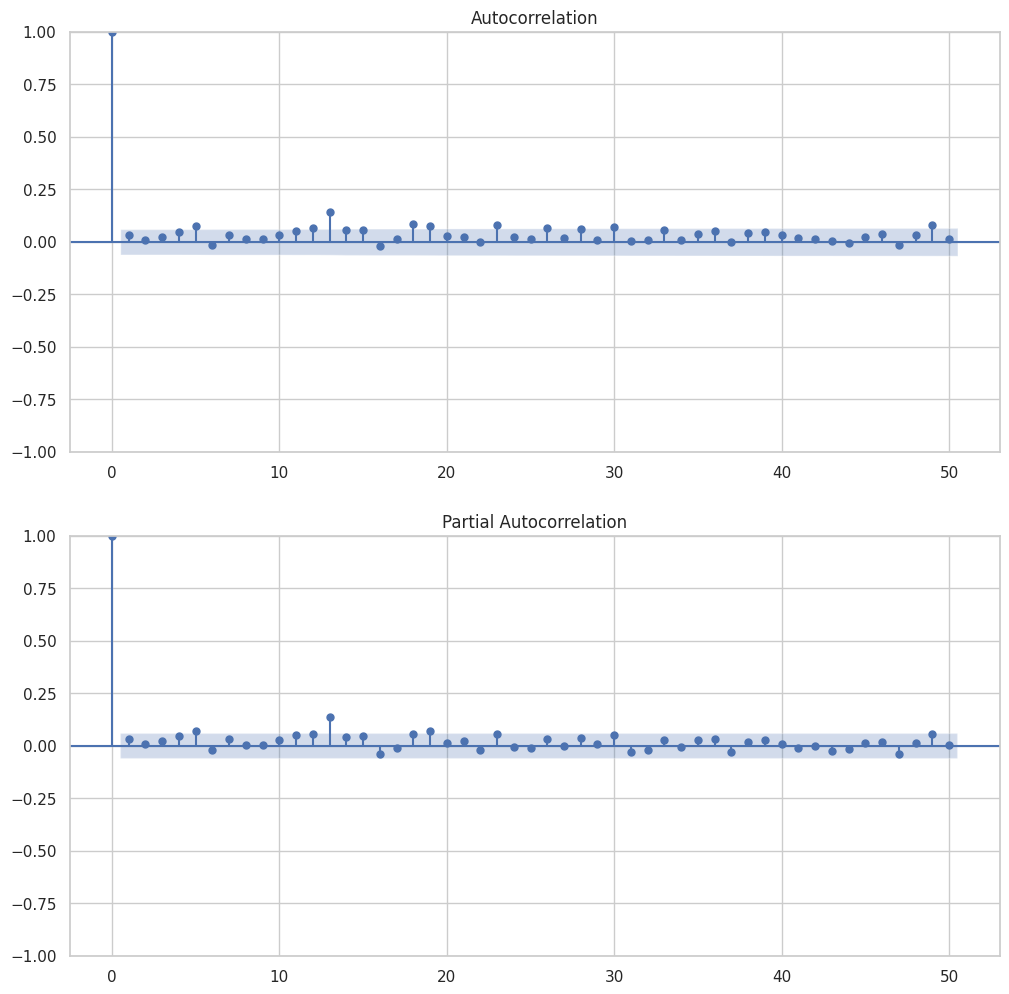

In [25]:
# ACF and PACF plots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the Autocorrelation Function (ACF)
plot_acf(train_data['DEP_DELAY'].dropna(), lags=50, ax=axes[0])
 
# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(train_data['DEP_DELAY'].dropna(), lags=50, ax=axes[1])

plt.show()


Performing ACF and PACF plots to identify the proper terms and lags to include in time series models for relevant forecasting.

There is a strong autocorrelation at lag 1 for both ACF and PACF which shows that the departure delay ('DEP_DELAY') of a given time is significantly influenced by the departure delay in the immediately preceding time period.


# Modelling

Starting with ARIMA(1, 0, 0) model which corresponds to a simple AR(1) model without the MA component, as there was no significant indication for MA terms from the ACF plot.

# ARIMA (1, 0, 0)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              DEP_DELAY   No. Observations:                 1096
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4977.653
Date:                Sat, 20 Apr 2024   AIC                           9961.305
Time:                        23:04:36   BIC                           9976.303
Sample:                    01-01-2019   HQIC                          9966.980
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0164      1.611      3.114      0.002       1.859       8.174
ar.L1          0.0331      0.032      1.049      0.294      -0.029       0.095
sigma2       689.6690     16.965     40.653      0.0

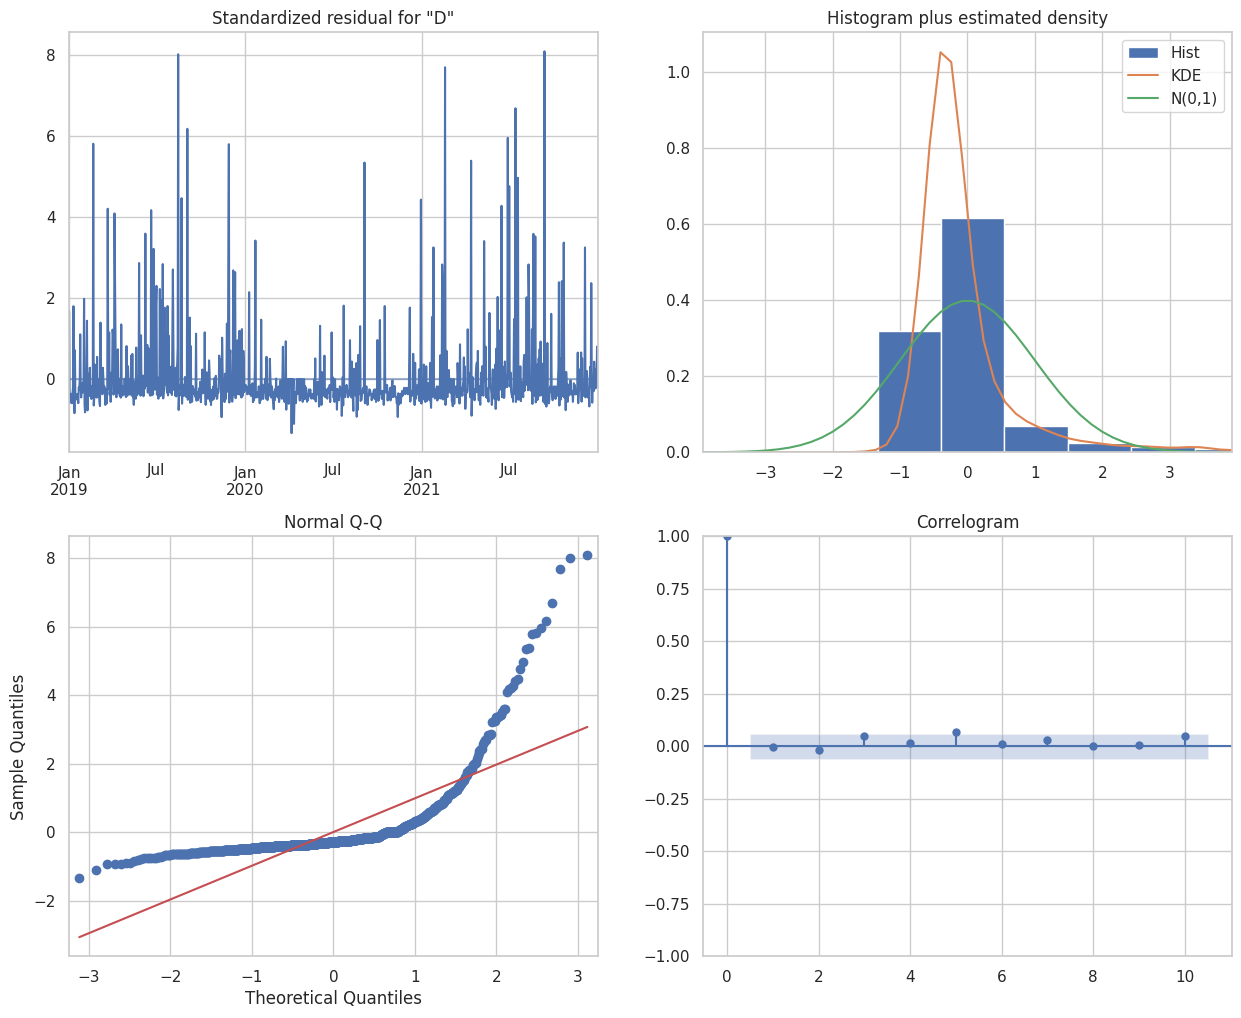

In [26]:
# Fitting the ARIMA(1, 0, 0) model
arima_model = ARIMA(train_data['DEP_DELAY'], order=(1, 0, 0))
arima_result = arima_model.fit()

# Printing out the summary of the model fit
arima_result_summary = arima_result.summary()
print(arima_result_summary)

# Plotting diagnostics to investigate any unusual behavior
arima_result.plot_diagnostics(figsize=(15, 12))
plt.show()


This model is not a good fit as the coefficient for the AR term is not significant and points towards including additional lags. The non-normality of residuals and substantial deviations in the Q-Q plot suggest that there might be non-linearity or other dynamics in the data. And there is a significant autocorrelation at lag 1 in the correlogram of the residuals which suggests that the model is inefficient in explain the temporal dependencies in the data.  

# ARIMA(1, 0, 1)

In [27]:
# Fitting the model
arima_model = ARIMA(train_data['DEP_DELAY'], order=(1, 0, 1))
arima_result = arima_model.fit()

# Printing out the summary
arima_result_summary = arima_result.summary()
print(arima_result_summary)


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              DEP_DELAY   No. Observations:                 1096
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4967.357
Date:                Sat, 20 Apr 2024   AIC                           9942.714
Time:                        23:04:38   BIC                           9962.712
Sample:                    01-01-2019   HQIC                          9950.281
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8824      4.050      1.205      0.228      -3.056      12.820
ar.L1          0.9889      0.009    106.982      0.000       0.971       1.007
ma.L1         -0.9675      0.017    -58.002      0.0

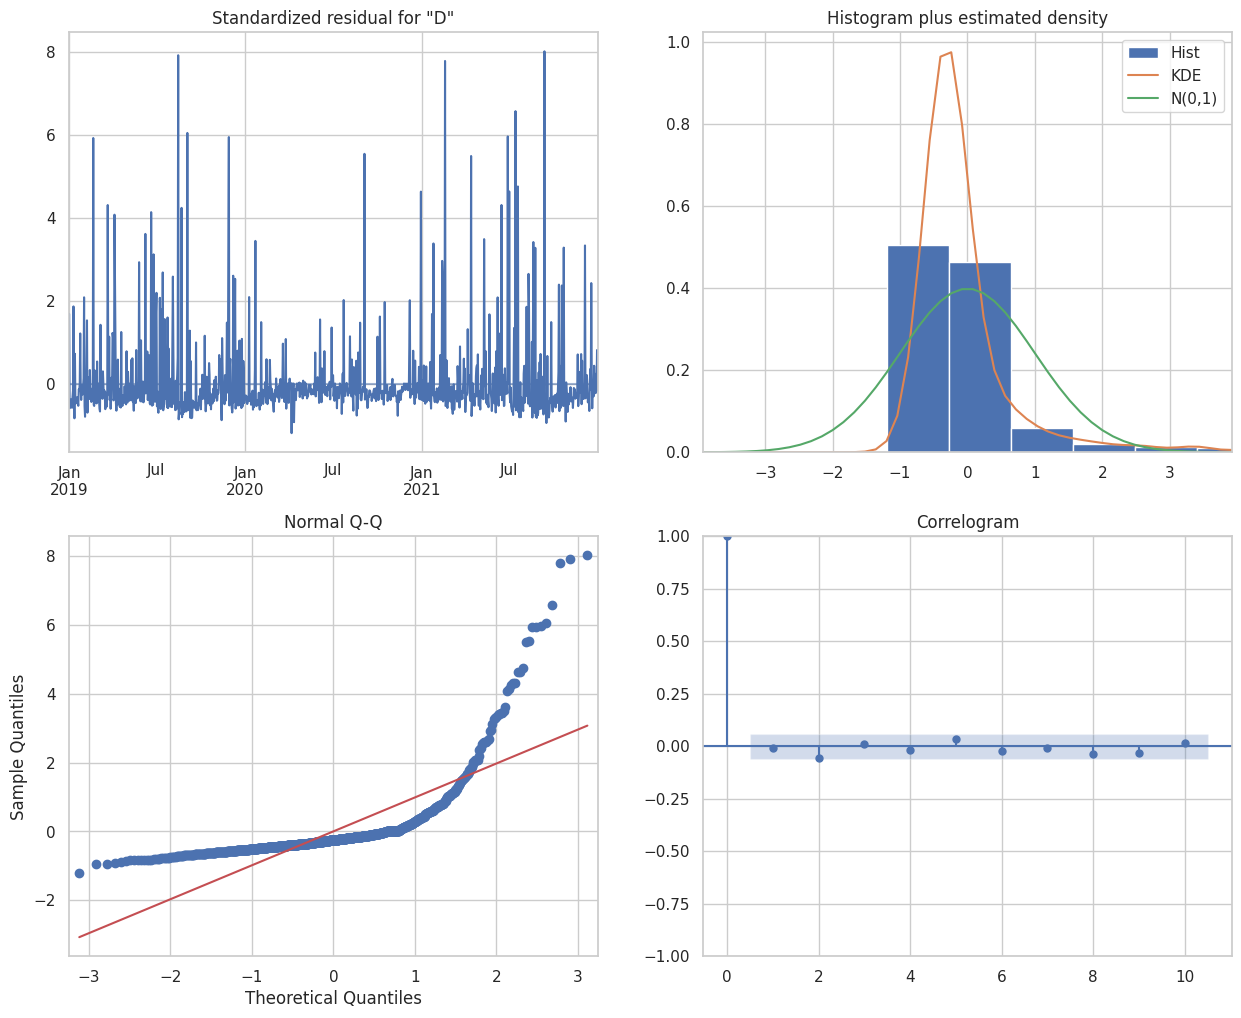

In [28]:
# Plotting the diagnostics
arima_result.plot_diagnostics(figsize=(15, 12))
plt.show()


In [29]:
# Getting the number of steps to forecast
steps_to_forecast = len(test_data)

# Generating forecasts
forecast_results = arima_result.get_forecast(steps=steps_to_forecast)


forecast_mean = forecast_results.predicted_mean
forecast_conf_int = forecast_results.conf_int()

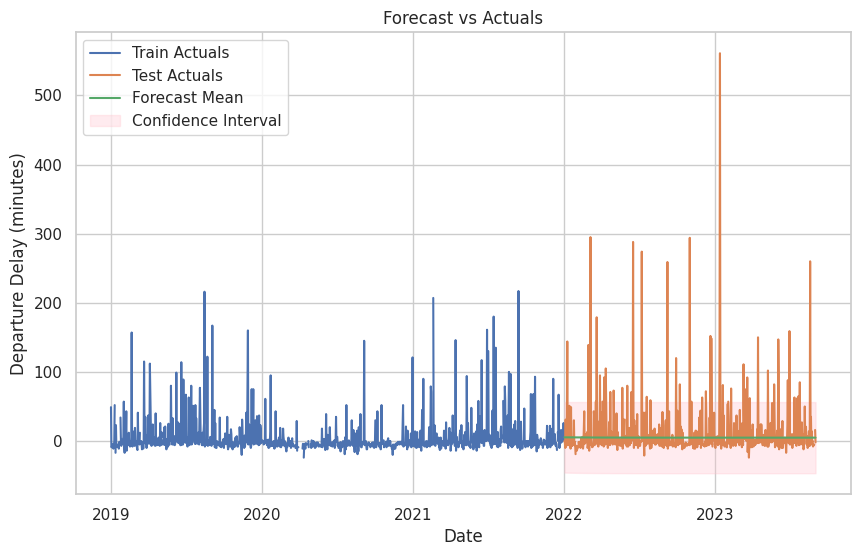

In [30]:
# Plotting the actual values
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['DEP_DELAY'], label='Train Actuals')
plt.plot(test_data.index, test_data['DEP_DELAY'], label='Test Actuals')

# Plot the predicted values (forecast_mean)
plt.plot(forecast_mean.index, forecast_mean, label='Forecast Mean')

# Plot the confidence intervals (from forecast_conf_int)
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int['lower DEP_DELAY'],
                 forecast_conf_int['upper DEP_DELAY'],
                 color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Departure Delay (minutes)')
plt.legend()
plt.show()


The ARIMA(1, 0, 1) model captures some of the autocorrelation structure of the data which can be concluded by the significant coefficients like 'ar.L1' coefficient is approximately -0.9889 with a p-value of 0.000, which is highly significant and 'ma.L1' coefficient is approximately 0.9765 with a p-value of 0.000, indicating a highly significant moving average component that positively affects the current value. However, the non-normality of the residuals and the spikes in the standardized residuals plot suggest that there may be additional complexity in the data not captured by the model.

# ARIMA (2, 0, 0)

In [31]:
arima_model_202 = ARIMA(train_data['DEP_DELAY'], order=(2, 0, 2))
arima_result_202 = arima_model_202.fit()

# summary of the model fit
print(arima_result_202.summary())



/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:              DEP_DELAY   No. Observations:                 1096
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -4965.427
Date:                Sat, 20 Apr 2024   AIC                           9942.855
Time:                        23:04:42   BIC                           9972.851
Sample:                    01-01-2019   HQIC                          9954.205
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8776      4.047      1.205      0.228      -3.055      12.810
ar.L1          0.0978      0.101      0.964      0.335      -0.101       0.297
ar.L2          0.8815      0.095      9.266      0.0

There are several issues in the model such as non-significant predictors and potential non-stationarity. Thereafter the diagnostic tests indicate good signs in terms of autocorrelation and heteroskedasticity but showcases that there is a problem with the normal distribution of residuals, concluding that the model is not the best fit. 

In [32]:
# Forecasting using the fitted model
forecast = arima_result_202.get_forecast(steps=len(test_data))

# The forecast object contains the predicted values, the standard error of predictions, and the confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()
forecast_se = forecast.se_mean

In [33]:
test_data_nonan = test_data.dropna()
forecast_values_nonan = forecast_values.dropna()

/tmp/ipykernel_18/2653910377.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['DEP_DELAY'] = pd.Series(test_data['DEP_DELAY'])


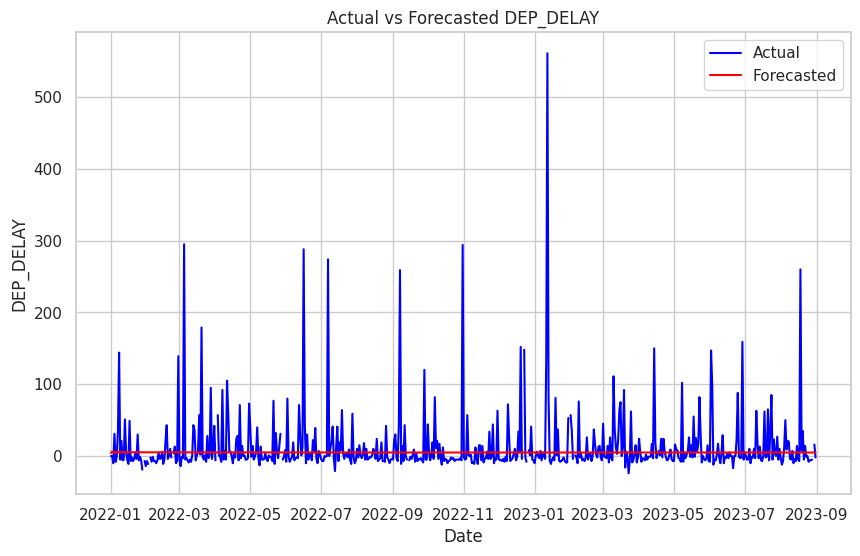

In [34]:
# Ensuring both forecast_values and test_data['DEP_DELAY'] are pandas Series
forecast_values = pd.Series(forecast_values)
test_data['DEP_DELAY'] = pd.Series(test_data['DEP_DELAY'])

# Aligning forecast_values and test_data on their common index
common_index = forecast_values.index.intersection(test_data['DEP_DELAY'].index)
forecast_values_aligned = forecast_values.loc[common_index]
test_data_aligned = test_data['DEP_DELAY'].loc[common_index]

# Plotting the actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(test_data_aligned.index, test_data_aligned, label='Actual', color='blue')
plt.plot(forecast_values_aligned.index, forecast_values_aligned, label='Forecasted', color='red')
plt.title('Actual vs Forecasted DEP_DELAY')
plt.xlabel('Date')
plt.ylabel('DEP_DELAY')
plt.legend()
plt.show()


The forecasted values appear to be relatively flat, which suggests the model might be underfitting the data and not responsive enough to changes over time.


I tried to incorporate the SARIMA model but it is extremely computationally demanding as it tries to include both non-seasonal and seasonal elements, each with its own autoregressive (AR) parameters, differencing (I), and moving average (MA) parameter. Hence choosing a simpler model ETS which is more straightforward and faster to compute than SARIMA models and are particularly useful when you need a model that can be quickly retrained and updated as new data becomes available.

#  Error, Trend, and Seasonality (ETS) model

In [35]:
flights_data.index = pd.to_datetime(flights_data.index)


In [36]:
flights_data = flights_data.asfreq('D')  # for daily frequency

In [37]:
# Making sure that the data does not contain zero or negative values before log transformation
train_data['DEP_DELAY'] = train_data['DEP_DELAY'] + 1  
train_data['Transformed_DEP_DELAY'] = np.log(train_data['DEP_DELAY'])

# Replacing them 
train_data['Transformed_DEP_DELAY'] = train_data['Transformed_DEP_DELAY'].replace([np.inf, -np.inf], np.nan)
train_data.dropna(subset=['Transformed_DEP_DELAY'], inplace=True)

# Fitting the ETS model with log-transformed data
ets_model = ExponentialSmoothing(
    train_data['Transformed_DEP_DELAY'],
    trend='add',
    seasonal='add',
    seasonal_periods=7,  # or another appropriate value based on your domain knowledge
    initialization_method='estimated'
)
ets_result = ets_model.fit()



/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [38]:
# Forecasting using the fitted model
steps_to_forecast = len(test_data)  
predictions = ets_result.forecast(steps=steps_to_forecast)


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [39]:
# Inversing the transformation for the predictions before comparing with the actual values
predictions = np.exp(predictions)


In [40]:
# Extracting the residuals
residuals = ets_result.resid

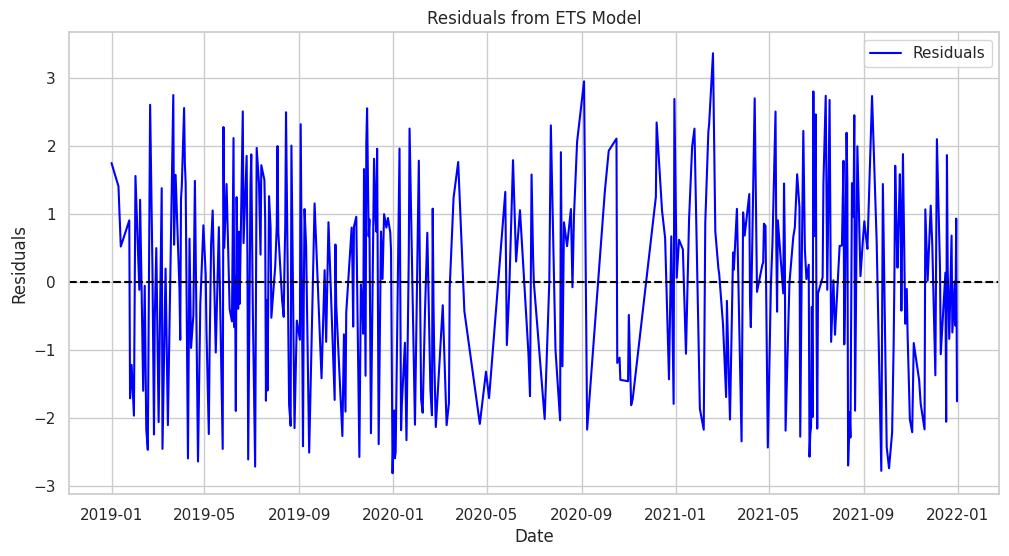

In [41]:
# Plotting the residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='blue')
plt.axhline(0, linestyle='--', color='black')  # Add a horizontal line at 0
plt.title('Residuals from ETS Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

The graph is shows the error of the model's predictions for flight departure delays over time. Since the residuals are not close to zero and there are spikes corresponding to specific days where delays were particularly unpredictable, we can conclude that the model consistently failed to predict the actual delay and needs to be improved.

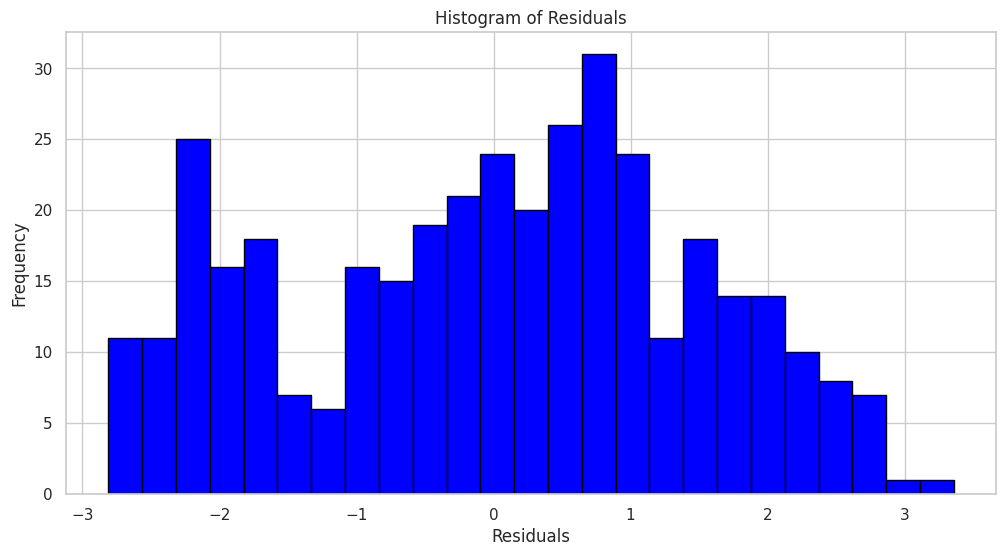

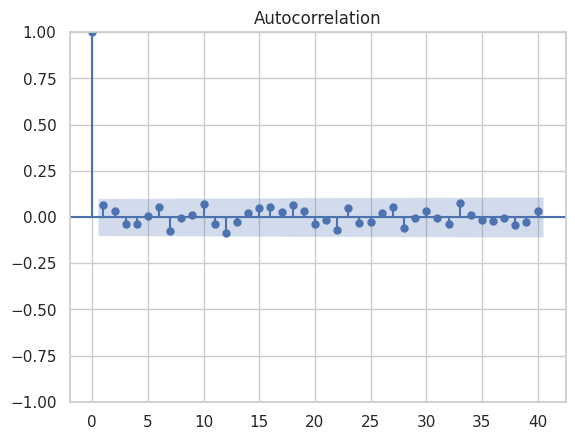

In [42]:
# Additional diagnostic plots
# Histogram of the residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=25, color='blue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# ACF plot of the residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=40)
plt.show()

In [43]:
#MAE and MSE for the training set
mae = np.mean(np.abs(residuals))
mse = np.mean(residuals**2)
print(f"MAE: {mae}, MSE: {mse}")

MAE: 1.2281075969308453, MSE: 2.1693632482796934


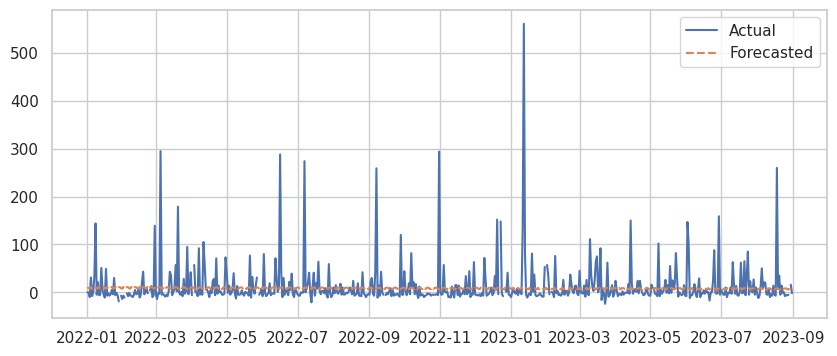

In [44]:
# Plotting the actual vs forecasted values
plt.figure(figsize=(10, 4))
plt.plot(test_data.index, test_data['DEP_DELAY'], label='Actual')
plt.plot(test_data.index[-steps_to_forecast:], predictions, label='Forecasted', linestyle='--')
plt.legend()
plt.show()


The model is underperforming and needs some parameters tunning. I was not sure about the spikes on the graph and therefore decided to proceed with anamoly detection and handle those and try the ETS model again. 

# Anomaly detection on the DEP_DELAY column

In [45]:
# Ensuring that there is no missing values in the 'DEP_DELAY' column
flights_data = flights_data.dropna(subset=['DEP_DELAY'])

# Initializing the IsolationForest model
iforest = IsolationForest(n_estimators=100, contamination=0.01)  # Adjust contamination if you have an expected outlier ratio

# Reshaping the data using .values.reshape(-1, 1) since there is a single feature
iforest.fit(flights_data[['DEP_DELAY']].values.reshape(-1, 1))

# Predicting the anomalies (-1 for outliers, 1 for inliers)
flights_data['anomaly'] = iforest.predict(flights_data[['DEP_DELAY']].values.reshape(-1, 1))

# Filtering out the anomalies to get a DataFrame without outliers
flights_data_no_anomaly = flights_data[flights_data['anomaly'] == 1]



In [46]:
split_date = pd.Timestamp('2021-12-31')

# Splitting the data into training and test sets
train_data_new = flights_data_no_anomaly.loc[flights_data_no_anomaly.index <= split_date]
test_data_new = flights_data_no_anomaly.loc[flights_data_no_anomaly.index > split_date]

In [47]:
train_series = train_data_new['DEP_DELAY']

# Fitting the ETS model on the training series
ets_model = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=365)
ets_fit = ets_model.fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [48]:
# Forecastting the future values using the fitted model
forecast_length = len(test_data_new)
forecast_values = ets_fit.forecast(steps=forecast_length)

# Adding the forecasted values to the test_data DataFrame for comparison
test_data_new['Forecast'] = forecast_values.values

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipykernel_18/725549561.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_new['Forecast'] = forecast_values.values


In [49]:
print(test_data_new['Forecast'])

FL_DATE
2022-01-01    13.192155
2022-01-02     6.958810
2022-01-03     0.934354
2022-01-04    -2.584612
2022-01-05     3.820858
                ...    
2023-08-26    -1.874817
2023-08-27     5.955610
2023-08-28    22.617883
2023-08-30    -1.256950
2023-08-31    21.499164
Name: Forecast, Length: 588, dtype: float64


In [50]:
forecasted_values_list = test_data_new['Forecast'].tolist()

In [51]:
count_of_items = len(forecasted_values_list)
print(count_of_items) # as the test_data is for about 2 years or 20 months. 

588


In [52]:
test_data_new.head()

,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,...,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,hour_of_day,day_of_week,month,season,is_weekend,distance_category,anomaly,Forecast
FL_DATE,,,,,,,,,,,,,,,,,,,,,
2022-01-01,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,567,LAX,"Los Angeles, CA",ATL,"Atlanta, GA",1310,...,NaN,NaN,13,5,1,1,1,Long,1,13.192155
2022-01-02,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,3593,GEG,"Spokane, WA",SEA,"Seattle, WA",1859,...,NaN,NaN,18,6,1,1,1,Very Short,1,6.958810
2022-01-03,Hawaiian Airlines Inc.,Hawaiian Airlines Inc.: HA,HA,19690,23,OAK,"Oakland, CA",OGG,"Kahului, HI",735,...,NaN,NaN,7,0,1,1,0,Very Long,1,0.934354
2022-01-04,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,750,EWR,"Newark, NJ",FLL,"Fort Lauderdale, FL",1805,...,NaN,NaN,18,1,1,1,0,Medium,1,-2.584612
2022-01-05,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,1739,CMH,"Columbus, OH",CLT,"Charlotte, NC",2004,...,NaN,NaN,20,2,1,1,0,Very Short,1,3.820858


In [53]:
test_data_new.to_csv('test_data_new.csv', index=False) # created this for the group project

/tmp/ipykernel_18/3052254385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_new['FL_DATE'] = test_data_new.index


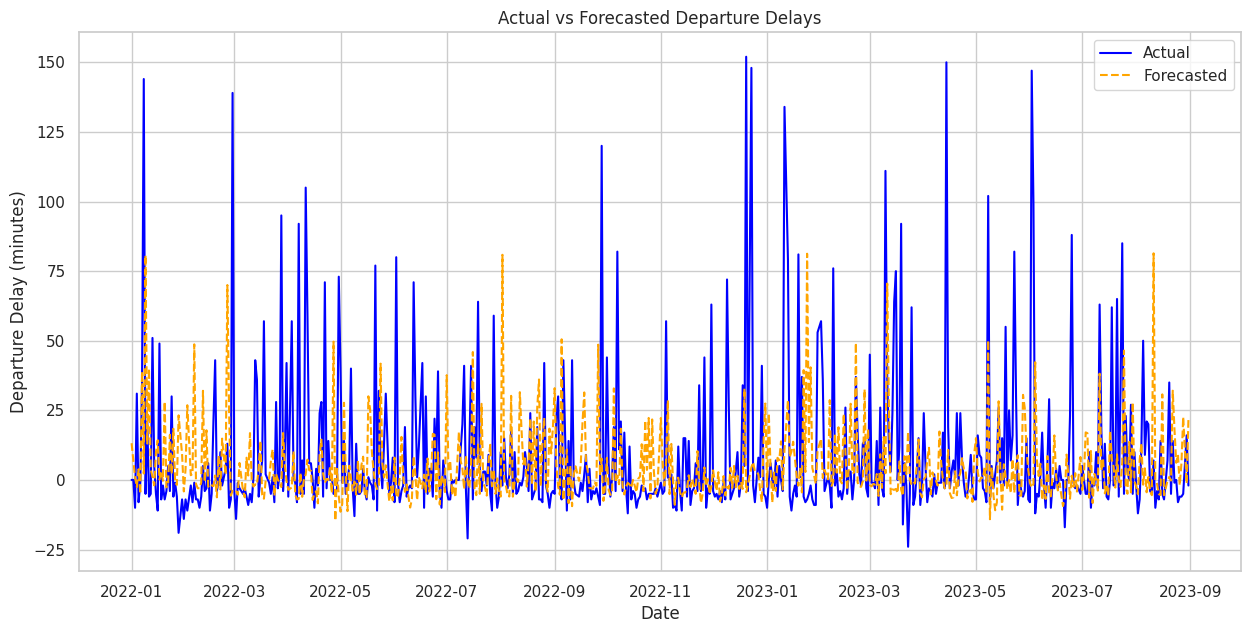

In [54]:
test_data_new['FL_DATE'] = test_data_new.index

plt.figure(figsize=(15, 7))
plt.plot(test_data_new['FL_DATE'], test_data_new['DEP_DELAY'], label='Actual', color='blue')
plt.plot(test_data_new['FL_DATE'], test_data_new['Forecast'], label='Forecasted', color='orange', linestyle='--')

plt.title('Actual vs Forecasted Departure Delays')
plt.xlabel('Date')
plt.ylabel('Departure Delay (minutes)')
plt.legend()
plt.show()


The forecasted values after the anamoly detection and handling is very close to the actual values of the test_data and the model is able to predict very closely to the actual values.

In [55]:
# Ensuring both are numpy arrays to facilitate calculations
actuals = np.array(test_data_new['DEP_DELAY'])
forecasts = np.array(ets_result.forecast(steps=len(test_data_new)))

# Mean Absolute Error
mae = np.mean(np.abs(forecasts - actuals))

# Mean Squared Error
mse = np.mean((forecasts - actuals) ** 2)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# Symmetric Mean Absolute Percentage Error 
smape = np.mean(2.0 * np.abs(forecasts - actuals) / (np.abs(actuals) + np.abs(forecasts))) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"SMAPE: {smape}%")


MAE: 15.171787599199833
MSE: 760.4291894598308
RMSE: 27.575880574513498
SMAPE: 173.624833217887%


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


The above error metrics gives more room for imorovement as on average the model’s forecasts are about 15 minutes away from the actual departure delay times. The provided values indicate the model has some predictive capability but is certainly not perfect. The errors suggest that while the forecast can capture the general pattern of departure delays, there are specific instances where it fails to predict accurately and some robust models such as SARIMA can be used for better prediction. 

# Limitations

I tried to incorporate a couple of other models as well but they were computationally demanding and there was no way to incorporate those. Some of these models were SARIMA and LSTM. MY forst choice was LSTM but I did not get anywhere using it and hence decided on ARIMA. Whereas due to the computational challenges of SARIMA , I further dived into ETS model. 